# First Machine Learning Approach for Physio Data

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import functionsMasterProjectMeinhart as fmpm

## Generate the reference signals for cross-correlation

For now this should be done by means of the datasets with 5 repetitions.

One repetition is considered as one data point for ML.

In total we have approximately 2700 data points $\rightarrow$ (5 + 10 + 15) rep. x 9 sub. x 10 exerc. (a few more or less because of incorrect exercise repetitions of some subjects).

If we take all data points from the 5-repetition sets we obtain a number of 450.

Moreover, the signals will be split into a defined number of equally distributed sections. For each section the mean will be calculated. Hence, all received signal arrays have same length.

***The first step is to extract all data of 5-repetition sets from the database (start_time, stop_time, csv-file), ***

***and to save them in a dictionary with the exercise abbreviations as keys.***

In [4]:
number_repetitions = 5

db_name='DataBase_Pysio.db' # database name

exercise_abbrs = ['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2'] # exercise abbreviations


# Connect to an existing database
conn = sqlite3.connect(db_name)
cur = conn.cursor()

# dictionary with the exercise abbreviation as key
data_5_rep = {}

for key in exercise_abbrs:
    # sql command to extract data
    query_sql = """
        SELECT r.start_time, r.stop_time, e.csv_file
        FROM subjects s
        INNER JOIN exercises e
        ON s.id = e.subject_id
        INNER JOIN paradigms p
        ON p.id = e.paradigm_id
        INNER JOIN repetitions r
        ON e.id = r.exercise_id
        WHERE p.abbreviation = '{}'
        AND e.num_rep = {}
        """.format(key, number_repetitions)

    # get data from data base and close connection
    data_5_rep[key] = pd.read_sql_query(query_sql, conn)
    
conn.close()

In [5]:
print('Head of one loaded data frame as an example:')
data_5_rep['RF'].head()

Head of one loaded data frame as an example:


,start_time,stop_time,csv_file
0,1.1482924107142871,3.699122023809525,subject01_RF_05.csv
1,3.699122023809525,6.49581473214286,subject01_RF_05.csv
2,6.49581473214286,9.384706101190478,subject01_RF_05.csv
3,9.384706101190478,12.073833705357146,subject01_RF_05.csv
4,12.073833705357146,14.809060639880954,subject01_RF_05.csv


In [6]:
print('Length of the individual data frames:')
count = 0
for key in exercise_abbrs:
    print(key + ':\t' + str(data_5_rep[key].shape[0]))
    count += data_5_rep[key].shape[0]
print('total:\t' + str(count))

Length of the individual data frames:
RF:	45
RO:	45
RS:	45
LR:	45
BC:	45
TC:	45
MP:	45
SA:	45
P1:	44
P2:	45
total:	449


As can be seen from the output above, there are not 450 data points because at exercise P1 one repetition is missing.

*** Function to split signals into equally distributed sections and calculating the mean ***

In [7]:
def split_into_sections(signal_data, num_sec=20, signals=['Acc','Gyr']):
    '''This Function splits the input signals data into a defined number 
    of equally distributed sections. For each signal and section the mean is calculated,
    and afterwards returned by means of a dictionary.
    
    Parameters
    ----------
    signal_data : dict
        Dictionary with the signals in the signals-argument as keys.
    
    num_sec : int
        Number of sections to split the signals.
        
    signals : list
        Keys to select signals in the signal_data dictionary.
        If no keys are provided, all keys of the signal_data
        dictionary are taken.
    
    Returns
    -------
    Dictionary with section means for each signal --> keys are same as the selected
    in the list "signals".
    '''
    
    # if no signals are given as keys, select all keys of the input dictionary
    if not signals:
        signals = [*signal_data]
    
    # number of input data points of each signal (signals have to be of the same length --> take index 0)
    len_signals = np.shape(signal_data[signals[0]])[0]
    
    # get indices of the sections (+1 due to start and end index of each section)
    sec_ind = np.linspace(0, len_signals, num_sec+1).round().astype(int)
    
    # dicitonary to save sections means for each signal
    section_means = {}

    for signal in signals:
        # generate row with zeros in order to use np.vstack afterwards
        section_means[signal] = np.zeros([1, np.shape(signal_data[signal])[1]])

        # add the mean of each section
        for ii in range(len(sec_ind)-1):
            section_means[signal] = np.vstack([section_means[signal], 
                                               np.mean(signal_data[signal][sec_ind[ii]:sec_ind[ii+1]], axis=0)])

        # delete the first row with the zeros
        section_means[signal] = np.delete(section_means[signal], 0, axis=0)
        
    return section_means

*** Load the data of the 5-repetition sets, split them into sections and calculate the overall section means***

In [8]:
# let's create a dictionary for the overall mean signals (considering all 5-repetition sets),
# which shall contain the reference signals for each exercise after calculating the mean
# of the sections of all individual section_means signals
overall_section_means = {}

number_sections = 20 # number sections to split the signals
csv_dir='E:\Physio_Data_Split_Exercise_done' # directory of csv files
sampling_rate = 256 # [Hz]
signals = ['Acc','Gyr'] # signals which shall be considered for the mean calculation

# go through all exercises
for ex in exercise_abbrs:
    overall_section_means[ex] = {}
    
    # go through all repetitions (data points) of the current exercise
    for ii in range(len(data_5_rep[ex])):
        
        # join file path
        file_path = os.path.join(csv_dir, data_5_rep[ex]['csv_file'][ii])
        
        # load the signal data of the corresponding time range of the current repetition
        selected_data = fmpm.get_sensor_data(in_file = file_path, 
                                             signals = signals, 
                                             sampling_rate = sampling_rate, 
                                             start_time = float(data_5_rep[ex]['start_time'][ii]), 
                                             stop_time = float(data_5_rep[ex]['stop_time'][ii]))
         
        # calculate the corresponding section means of the current repetition
        section_means = split_into_sections(signal_data = selected_data,
                                            num_sec = number_sections,
                                            signals = signals)
        
        # calculate the overall section means
        if ii is 0: # first run only copy
            for sig in signals:
                overall_section_means[ex][sig] = section_means[sig] / len(data_5_rep[ex])
                
        else: # further runs add to existing values
            for sig in signals:
                overall_section_means[ex][sig] += (section_means[sig] / len(data_5_rep[ex]))  


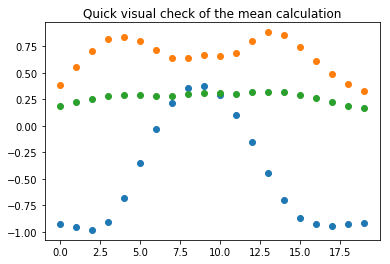

In [9]:
# let's check one example signal
plt.plot(overall_section_means['RF']['Acc'], 'o')
plt.title('Quick visual check of the mean calculation');

## Feature generation: norm. cross-correlation with the calculated reference signals

So far, the reference signals for the normalized cross-correlation have been calculated (in total 60 reference signals $\rightarrow$ (3 x Acc + 3 x Gyr) x 10 exercises)

Hence, for each repetition (data point) we have to perform the cross-correlation 60 times.

Afterwards the norm. cross-correlation value at complete overlapping of the signals will be taken as feature of the current data point (*scipy.signal.correlate* $\rightarrow$ *mode: "valid"*). If the number of sections is not equal for two signals, the maximum value of the cross-correlation is taken (but this should not be the case).

Since we already used the 5-repetition sets, there are 2250 untouched data points left $\rightarrow$ (10 + 15) rep. x 9 sub. x 10 exercises

***The next step is to extract all data of 10- and 15-repetition sets from the database (start_time, stop_time, csv-file), ***

***and to save them in a dictionary with the exercise abbreviations as keys.***

In [10]:
# Connect to an existing database
conn = sqlite3.connect(db_name)
cur = conn.cursor()

# dictionary with the exercise abbreviation as key
data_10_15_rep = {}

for key in exercise_abbrs:
    # sql command to extract data
    query_sql = """
        SELECT r.start_time, r.stop_time, e.csv_file
        FROM subjects s
        INNER JOIN exercises e
        ON s.id = e.subject_id
        INNER JOIN paradigms p
        ON p.id = e.paradigm_id
        INNER JOIN repetitions r
        ON e.id = r.exercise_id
        WHERE p.abbreviation = '{}'
        AND (e.num_rep = {} OR e.num_rep = {})
        """.format(key, 10, 15)

    # get data from data base and close connection
    data_10_15_rep[key] = pd.read_sql_query(query_sql, conn)
    
conn.close()

In [11]:
print('Length of the individual data frames:')
count = 0
for key in exercise_abbrs:
    print(key + ':\t' + str(data_10_15_rep[key].shape[0]))
    count += data_10_15_rep[key].shape[0]
print('total:\t' + str(count))

Length of the individual data frames:
RF:	224
RO:	225
RS:	225
LR:	226
BC:	228
TC:	228
MP:	227
SA:	228
P1:	226
P2:	224
total:	2261


As we can see from above, there are a few more than 2250 data points, because obviously some exercises were performed with too much repetitions. 

***The next step is to create a csv-file for all 2261 untouched data points with the aforementioned 60 features for each data point.***

(Let's also add the label (exercise) for each data point.)

In [12]:
feature_csv_file = '1_ML_Approach_Features/features_crosscorr.csv' #  csv-file to save the features

# putting the header of the feature-file together --> contains the reference signals for cross-correlation
header_string = 'label;' # first column contains the labels

for ex in exercise_abbrs:
    for sig in signals:
        for ax in ['_x','_y','_z']:
            header_string +=  ex + '_' + sig + ax + ';'

# remove last separator (;)
idx_last_sep = header_string.rfind(";")
header_string =  header_string[:idx_last_sep]

# write header to file
with open(feature_csv_file, 'w') as feature_file:
    feature_file.writelines(header_string + '\n')


# let's load the data of the untouched data points and split them into sections (almost same as before)
# --> then we can apply the cross-correlation

# go through all exercises
for ex in exercise_abbrs:
    
    # go through all repetitions (data points) of the current exercise
    for ii in range(len(data_10_15_rep[ex])):
        
        # join file path
        file_path = os.path.join(csv_dir, data_10_15_rep[ex]['csv_file'][ii])
        
        # load the signal data of the corresponding time range of the current repetition
        selected_data = fmpm.get_sensor_data(in_file = file_path, 
                                             signals = signals, 
                                             sampling_rate = sampling_rate, 
                                             start_time = float(data_10_15_rep[ex]['start_time'][ii]), 
                                             stop_time = float(data_10_15_rep[ex]['stop_time'][ii]))
         
        # calculate the corresponding section means of the current repetition
        section_means = split_into_sections(signal_data = selected_data,
                                            num_sec = number_sections,
                                            signals = signals)
        
        # string to write data of the current data points to the csv-file
        data_point_string = ex + ';' # first column contains the labels
        
        # calculate the overall section means
        for ex_inner in exercise_abbrs:
            for sig in signals:
                for ii in [0,1,2]: # x, y, z comp. of the corresponding signal
                    corr = fmpm.norm_cross_corr(overall_section_means[ex_inner][sig][:,ii],
                                                section_means[sig][:,ii],
                                                mode='valid')
                    
                    # append to string for writing to csv file (5 decimals)
                    data_point_string += "{:.5f};".format(np.max(corr)) # np.max only necess. if diff. num. of sections

        # remove last separator (;)
        idx_last_sep = data_point_string.rfind(";")
        data_point_string =  data_point_string[:idx_last_sep]
        
        # append values of current data point to file
        with open(feature_csv_file, 'a') as feature_file:
            feature_file.writelines(data_point_string + '\n')
                    

***Now all the features are calculated and saved to a csv-file. Let's now load the feature data with pandas.***

In [13]:
feature_csv_file = '1_ML_Approach_Features/features_crosscorr.csv'
feature_data = pd.read_csv(feature_csv_file, skiprows=0, sep=';')

In [14]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261 entries, 0 to 2260
Data columns (total 61 columns):
label       2261 non-null object
RF_Acc_x    2261 non-null float64
RF_Acc_y    2261 non-null float64
RF_Acc_z    2261 non-null float64
RF_Gyr_x    2261 non-null float64
RF_Gyr_y    2261 non-null float64
RF_Gyr_z    2261 non-null float64
RO_Acc_x    2261 non-null float64
RO_Acc_y    2261 non-null float64
RO_Acc_z    2261 non-null float64
RO_Gyr_x    2261 non-null float64
RO_Gyr_y    2261 non-null float64
RO_Gyr_z    2261 non-null float64
RS_Acc_x    2261 non-null float64
RS_Acc_y    2261 non-null float64
RS_Acc_z    2261 non-null float64
RS_Gyr_x    2261 non-null float64
RS_Gyr_y    2261 non-null float64
RS_Gyr_z    2261 non-null float64
LR_Acc_x    2261 non-null float64
LR_Acc_y    2261 non-null float64
LR_Acc_z    2261 non-null float64
LR_Gyr_x    2261 non-null float64
LR_Gyr_y    2261 non-null float64
LR_Gyr_z    2261 non-null float64
BC_Acc_x    2261 non-null float64
BC_Acc_y  

In [15]:
feature_data.head()

,label,RF_Acc_x,RF_Acc_y,RF_Acc_z,RF_Gyr_x,RF_Gyr_y,RF_Gyr_z,RO_Acc_x,RO_Acc_y,RO_Acc_z,...,P1_Acc_z,P1_Gyr_x,P1_Gyr_y,P1_Gyr_z,P2_Acc_x,P2_Acc_y,P2_Acc_z,P2_Gyr_x,P2_Gyr_y,P2_Gyr_z
0,RF,0.94950,0.63657,0.33678,0.35271,0.91344,0.94759,0.97465,0.80981,0.30916,...,0.10690,0.21447,-0.86191,-0.90899,0.96287,0.27408,0.20157,-0.03811,0.92826,0.96336
1,RF,0.97405,0.91499,0.87064,-0.08410,0.89427,0.96328,0.94497,0.81997,0.83718,...,0.07177,0.25173,-0.91718,-0.88062,0.88762,-0.31898,-0.37692,0.39862,0.83440,0.78937
2,RF,0.99311,0.94955,0.40769,0.12533,0.90966,0.98963,0.97536,0.86841,0.25713,...,0.40813,-0.22589,-0.86365,-0.88996,0.93094,-0.33430,0.26232,-0.41034,0.84015,0.84003
3,RF,0.98944,0.83555,-0.18043,-0.03240,0.69212,0.98746,0.97373,0.84098,-0.21924,...,-0.12769,-0.18700,-0.65825,-0.91569,0.93415,-0.13922,0.25964,-0.27997,0.61697,0.87918
4,RF,0.99761,0.86110,0.13332,0.38439,0.92986,0.99100,0.98569,0.83571,0.02608,...,0.42417,-0.13826,-0.91454,-0.92551,0.94117,-0.08891,0.61446,-0.17528,0.89729,0.88215


*** Let's quickly check visually the correlation between a few features (not necessary)***

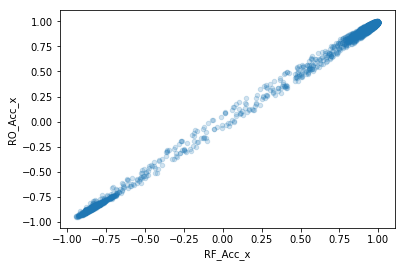

In [16]:
feature_data.plot(kind="scatter", x="RF_Acc_x", y="RO_Acc_x",alpha=0.2)
plt.show()

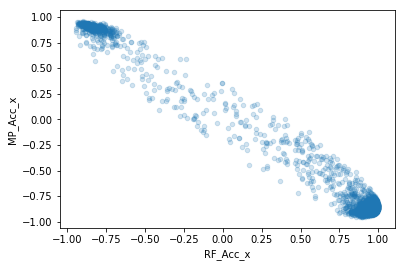

In [17]:
feature_data.plot(kind="scatter", x="RF_Acc_x", y="MP_Acc_x",alpha=0.2)
plt.show()

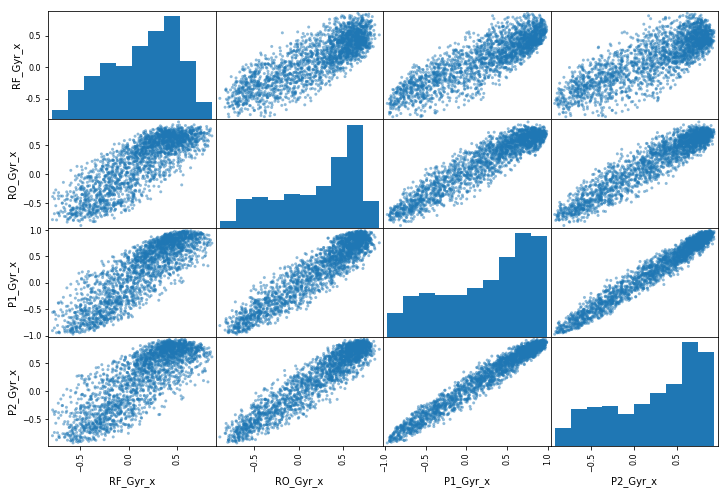

In [18]:
from pandas.plotting import scatter_matrix

attributes = ["RF_Gyr_x", "RO_Gyr_x", "P1_Gyr_x","P2_Gyr_x"]
scatter_matrix(feature_data[attributes], figsize=(12, 8));

## Classification

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [20]:
# get feature matrix X
X = feature_data.values[:,1:]
np.shape(X)

(2261, 60)

In [22]:
# dictionary for labels
label_ex = {'RF':0,
            'RO':1,
            'RS':2,
            'LR':3,
            'BC':4,
            'TC':5,
            'MP':6,
            'SA':7,
            'P1':8,
            'P2':9}

# get label array with labels (0 ... 9)
y = [label_ex[feature_data.values[ii,0]] for ii in range(len(feature_data.values[:,0]))]
np.shape(y)

(2261,)

In [2]:
colors = ['red', 'green', 'blue']
for ii, color in enumerate(colors):
    print('#{0}: {1}'.format(ii, color))

#0: red
#1: green
#2: blue


### Split the untouched data points (10 + 15 repetition sets) into train (75%) and test (25%) data sets

Use *stratify=y* to ensure that there is approximately the same number of each label (exercise) in the training set.  

In [20]:
# split the data in train and test set (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
print('Train set shape: {}'.format(np.shape(X_train)))
print('Test set shape:  {}'.format(np.shape(X_test)))

Train set shape: (1695, 60)
Test set shape:  (566, 60)


In [21]:
def print_precision_recall_accuracy():
    print('Exercise\tPrecision [%]\tRecall [%]\tAccuracy[%]')
    
    for ex in exercise_abbrs:
        TP = sum((y_pred == label_ex[ex]) & (np.array(y_test) == label_ex[ex])) # True Positives
        TN = sum((y_pred != label_ex[ex]) & (np.array(y_test) != label_ex[ex])) # True Negatives
        FP = sum((y_pred == label_ex[ex]) & (np.array(y_test) != label_ex[ex])) # False Positives
        FN = sum((y_pred != label_ex[ex]) & (np.array(y_test) == label_ex[ex])) # False Negatives

        precision = TP / (TP+FP)
        recall = TP / (TP+FN)
        accuracy = (TP+TN) / (TP+TN+FP+FN)
        
        print('  '+ ex +'\t\t  {:6.2f}'.format(precision*100)+ \
              '\t  {:6.2f}'.format(recall*100)+'\t  {:6.2f}'.format(accuracy*100))

### Random Forest Classifier

In [22]:
# apply a random forest classifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=40, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

print('Total Accuracy: {:.5f}'.format((accuracy_score(y_test, y_pred))))

Total Accuracy: 0.96113


In [23]:
print_precision_recall_accuracy()

Exercise	Precision [%]	Recall [%]	Accuracy[%]
  RF		   93.10	   96.43	   98.94
  RO		   92.31	   85.71	   97.88
  RS		   96.43	   96.43	   99.29
  LR		  100.00	   96.49	   99.65
  BC		  100.00	  100.00	  100.00
  TC		   98.21	   96.49	   99.47
  MP		   90.32	   98.25	   98.76
  SA		  100.00	   98.25	   99.82
  P1		  100.00	  100.00	  100.00
  P2		   91.23	   92.86	   98.41


In [24]:
# display the misclassified data points

ind_misclassified = np.flatnonzero(y_test != y_pred) # indices of misclassified data points

exercise_abbrs = ['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2'] # exercise abbreviations

print('{0} misclassified ({1} test data points)'.format(sum(y_test != y_pred), len(y_test)))
for ii in ind_misclassified:
    print(exercise_abbrs[y_test[ii]] + ' classified as ' + exercise_abbrs[y_pred[ii]])

22 misclassified (566 test data points)
P2 classified as MP
P2 classified as MP
RS classified as RO
P2 classified as RO
MP classified as TC
RF classified as RO
SA classified as MP
P2 classified as MP
RF classified as RO
RO classified as RF
RS classified as P2
RO classified as RS
RO classified as RS
RO classified as RF
RO classified as P2
TC classified as MP
RO classified as RF
TC classified as MP
LR classified as P2
LR classified as P2
RO classified as P2
RO classified as RF


### Voting Classifier

In [25]:
# use a voting classifier with the following classifiers:
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=40, n_jobs=-1, random_state=42)
svm_clf = SVC(kernel="poly", degree=3, coef0=1, C=5, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

print('Total Accuracy:')
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    print(clf.__class__.__name__, '{:.5f}'.format(accuracy_score(y_test, y_pred)))
print('\n')

E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in versi

Total Accuracy:
LogisticRegression 0.98233
RandomForestClassifier 0.98233
SVC 0.98233
VotingClassifier 0.98233




In [26]:
print_precision_recall_accuracy()

Exercise	Precision [%]	Recall [%]	Accuracy[%]
  RF		   96.23	   91.07	   98.76
  RO		   91.53	   96.43	   98.76
  RS		  100.00	  100.00	  100.00
  LR		  100.00	   98.25	   99.82
  BC		  100.00	  100.00	  100.00
  TC		  100.00	  100.00	  100.00
  MP		   96.61	  100.00	   99.65
  SA		  100.00	  100.00	  100.00
  P1		  100.00	  100.00	  100.00
  P2		   98.18	   96.43	   99.47


In [27]:
# display the misclassified data points

ind_misclassified = np.flatnonzero(y_test != y_pred) # indices of misclassified data points

print('{0} misclassified ({1} test data points)'.format(sum(y_test != y_pred), len(y_test)))
for ii in ind_misclassified:
    print(exercise_abbrs[y_test[ii]] + ' classified as ' + exercise_abbrs[y_pred[ii]])

10 misclassified (566 test data points)
P2 classified as MP
RF classified as RO
RF classified as RO
RF classified as RO
P2 classified as MP
RF classified as RO
RO classified as RF
RF classified as RO
RO classified as RF
LR classified as P2


### Linear Discriminant Analysis as Classifier

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
y_pred = lda_clf.predict(X_test)

print('Total Accuracy: {:.5f}'.format((accuracy_score(y_test, y_pred))))

Total Accuracy: 0.92580


In [29]:
print_precision_recall_accuracy()

Exercise	Precision [%]	Recall [%]	Accuracy[%]
  RF		   77.97	   82.14	   95.94
  RO		   75.47	   71.43	   94.88
  RS		  100.00	   96.43	   99.65
  LR		   94.83	   96.49	   99.12
  BC		  100.00	  100.00	  100.00
  TC		   98.21	   96.49	   99.47
  MP		   96.15	   87.72	   98.41
  SA		  100.00	  100.00	  100.00
  P1		   98.28	  100.00	   99.82
  P2		   85.48	   94.64	   97.88


In [30]:
# display the misclassified data points

ind_misclassified = np.flatnonzero(y_test != y_pred) # indices of misclassified data points

print('{0} misclassified ({1} test data points)'.format(sum(y_test != y_pred), len(y_test)))
for ii in ind_misclassified:
    print(exercise_abbrs[y_test[ii]] + ' classified as ' + exercise_abbrs[y_pred[ii]])

42 misclassified (566 test data points)
RO classified as RF
RF classified as RO
RS classified as RO
TC classified as LR
RO classified as RF
P2 classified as MP
RF classified as RO
P2 classified as LR
RF classified as RO
RO classified as RF
RF classified as RO
RF classified as RO
RO classified as RF
MP classified as P2
RO classified as RF
RO classified as RF
MP classified as TC
P2 classified as MP
RF classified as RO
RF classified as RO
RO classified as RF
MP classified as P2
RO classified as P2
RO classified as RF
RS classified as RO
RO classified as P2
RO classified as RF
RF classified as RO
RF classified as RO
MP classified as P2
LR classified as P2
MP classified as P1
TC classified as LR
RO classified as RF
RF classified as RO
MP classified as RO
LR classified as P2
RO classified as P2
MP classified as P2
RO classified as RF
RO classified as RF
RO classified as RF
